In [57]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

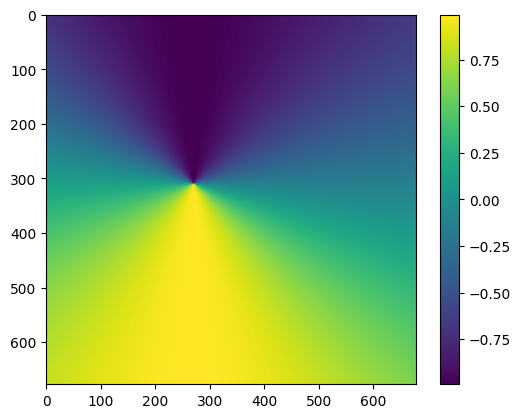

In [59]:

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)
alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2


plt.imshow(alpha_y_arcsec)   #assume this is in arcsec
plt.colorbar()

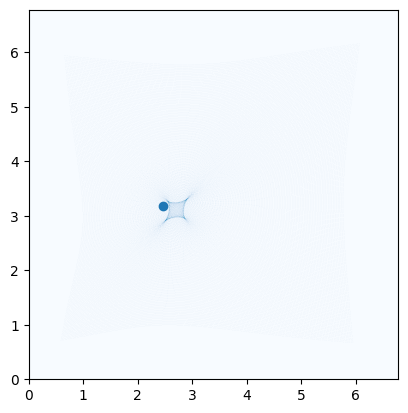

In [77]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 678* pixscale, 0])
plt.gca().invert_yaxis()
plt.scatter(2.47, 3.18)

In [61]:
x_grid = np.linspace(0, size-1, size)
x_grid = x_grid * pixscale

In [79]:
# Assuming deflection maps are stored in alpha_x_map and alpha_y_map
# and that they are on a grid defined by x_grid and y_grid

# Set up the interpolated lens model
lens_model_list = ['INTERPOL']
kwargs_lens = [{'grid_interp_x': x_grid, 'grid_interp_y': x_grid,
                          'f_x': alpha_x_arcsec, 'f_y': alpha_y_arcsec}]

lens_model = LensModel(lens_model_list=lens_model_list)

# Define source position
beta_x, beta_y = 2.47, 3.18
# Use lens equation solver
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver = LensEquationSolver(lens_model)

# Solve for image positions
possible_solutions = solver.candidate_solutions(beta_x, beta_y, kwargs_lens,verbose= True)
print(possible_solutions)
image_positions = solver.image_position_from_source(beta_x,beta_y,kwargs_lens)

print(image_positions)

(array([2.95, 3.15, 3.45, 1.65]), array([2.25, 2.35, 3.25, 3.85]), array([0.09362676, 0.10052959, 0.00976235, 0.03036147]), 0.09999999999999964)


IndexError: tuple index out of range